In [1]:
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import torch.nn.functional as F

import math


In [2]:

import torchvision
import torchvision.transforms as transforms


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=64,shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=64, shuffle=False)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']



100%|██████████| 170M/170M [07:25<00:00, 383kB/s]  


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49473685..1.5632443].


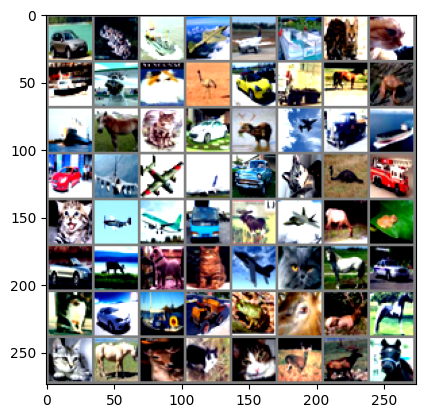

automobile frog ship airplane airplane ship cat cat ship airplane cat bird automobile truck horse frog ship horse cat automobile deer airplane truck ship automobile airplane airplane airplane automobile cat bird truck cat airplane airplane truck deer airplane deer frog automobile deer dog cat airplane cat horse automobile cat automobile ship truck frog deer deer horse cat horse deer cat cat deer deer horse


In [3]:


import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5  
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(trainloader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images))
print(' '.join(f'{classes[labels[j]]}' for j in range(64)))


In [4]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [5]:

class PatchEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.image_size = config["image_size"]
        self.patch_size = config["patch_size"]
        self.num_channels = config["num_channels"]
        self.hidden_size = config["hidden_size"]

        self.num_patches = (self.image_size // self.patch_size) ** 2

        # Linear projection of flattened patches
        self.projection = nn.Conv2d(
            self.num_channels, 
            self.hidden_size, 
            kernel_size=self.patch_size, 
            stride=self.patch_size
        )

    def forward(self, x):
        # (batch_size, num_channels, image_size, image_size) -> (batch_size, num_patches, hidden_size)
        x = self.projection(x)
        x = x.flatten(2).transpose(1, 2)
        return x


class MultiHeadDifferentialAttention(nn.Module):

    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(embed_dim, embed_dim * 3)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, N, D = x.shape  

        qkv = self.qkv_proj(x) 
        qkv = qkv.reshape(B, N, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4) 
        q, k, v = qkv[0], qkv[1], qkv[2]  


        k_padded = torch.cat([torch.zeros_like(k[:, :, :1, :]), k], dim=2)  
        diff_k = k_padded[:, :, 1:, :] - k_padded[:, :, :-1, :] 

        attn_weights = torch.matmul(q, diff_k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        attn_probs = F.softmax(attn_weights, dim=-1)
        attn_probs = self.dropout(attn_probs)

        context = torch.matmul(attn_probs, v)
        
        context = context.transpose(1, 2).reshape(B, N, D)

        out = self.out_proj(context)
        return out


class DiffViTEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_heads, dropout=0.0):
        super().__init__()

        self.norm1 = nn.LayerNorm(input_dim)

        self.attn = MultiHeadDifferentialAttention(input_dim, num_heads, dropout)
 
        self.norm2 = nn.LayerNorm(input_dim)

        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, input_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):

        x = x + self.attn(self.norm1(x))

        x = x + self.mlp(self.norm2(x))
        return x


class DiffViTClassifier(nn.Module):
    def __init__(
        self, image_size, patch_size, num_channels, embed_dim, hidden_dim, num_heads,
        num_layers, num_classes, dropout=0.0
    ):
        super().__init__()
        
        patch_config = {
            "image_size": image_size,
            "patch_size": patch_size,
            "num_channels": num_channels,
            "hidden_size": embed_dim
        }

        self.patch_embedding = PatchEmbeddings(patch_config)
        self.num_patches = self.patch_embedding.num_patches
        
 
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.num_patches + 1, embed_dim))
        
       

        nn.init.trunc_normal_(self.cls_token, std=0.02)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        
        self.dropout = nn.Dropout(dropout)
        
    
        self.transformer = nn.Sequential(
            *[DiffViTEncoder(embed_dim, hidden_dim, num_heads, dropout) for _ in range(num_layers)]
        )
        
       
        self.norm = nn.LayerNorm(embed_dim)
   
        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
    
        B = x.shape[0]
        
    
        x = self.patch_embedding(x)  
        
      
        cls_tokens = self.cls_token.expand(B, -1, -1) 
        x = torch.cat((cls_tokens, x), dim=1)  
        
        x = x + self.pos_embed  
        x = self.dropout(x)
        
      
        x = self.transformer(x)
        
      
        x = self.norm(x)
        
        
        x = x[:, 0]  # (B, embed_dim)
        
    
        x = self.head(x)  # (B, num_classes)
        
        return x

In [6]:
image_size = 32  
patch_size = 4   
num_channels = 3 
embed_dim = 192   
hidden_dim = 768 
num_heads = 8 
num_layers = 6
num_classes = 10  
dropout = 0.1
    
model = DiffViTClassifier(
    image_size=image_size,
    patch_size=patch_size,
    num_channels=num_channels,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_heads=num_heads,
    num_layers=num_layers,
    num_classes=num_classes,
    dropout=dropout
)
model = model.to(device)
    

Epoch [1/30], Step [100/782], Loss: 2.0046, Acc: 24.98%
Epoch [1/30], Step [200/782], Loss: 1.8532, Acc: 28.40%
Epoch [1/30], Step [300/782], Loss: 1.7744, Acc: 30.20%
Epoch [1/30], Step [400/782], Loss: 1.7194, Acc: 32.02%
Epoch [1/30], Step [500/782], Loss: 1.6751, Acc: 33.25%
Epoch [1/30], Step [600/782], Loss: 1.6069, Acc: 34.44%
Epoch [1/30], Step [700/782], Loss: 1.6218, Acc: 35.40%
Epoch [1/30] - Test Loss: 1.6282, Test Acc: 39.82%
Epoch [2/30], Step [100/782], Loss: 1.5016, Acc: 45.45%
Epoch [2/30], Step [200/782], Loss: 1.4877, Acc: 45.84%
Epoch [2/30], Step [300/782], Loss: 1.4706, Acc: 46.33%
Epoch [2/30], Step [400/782], Loss: 1.4522, Acc: 46.72%
Epoch [2/30], Step [500/782], Loss: 1.4285, Acc: 46.91%
Epoch [2/30], Step [600/782], Loss: 1.4106, Acc: 47.23%
Epoch [2/30], Step [700/782], Loss: 1.4086, Acc: 47.40%
Epoch [2/30] - Test Loss: 1.4101, Test Acc: 49.19%
Epoch [3/30], Step [100/782], Loss: 1.3363, Acc: 51.73%
Epoch [3/30], Step [200/782], Loss: 1.3347, Acc: 51.75%
Ep

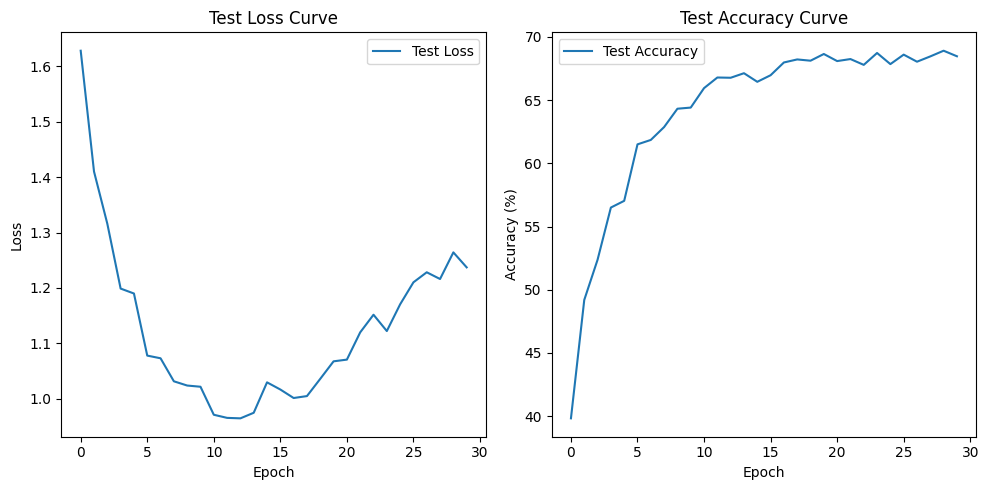

In [7]:
num_epochs=30 
batch_size=64
learning_rate=1e-4  
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=learning_rate)
 

train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []
    

for epoch in range(num_epochs):
        # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
        
    for i, (inputs, labels) in enumerate(trainloader):
        inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
        optimizer.zero_grad()
            
            # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
            
            # Backward pass and optimize
        loss.backward()
        optimizer.step()
            
            # Compute statistics
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
            
            # Print progress
        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], '
                   f'Loss: {running_loss/100:.4f}, Acc: {100.*correct/total:.2f}%')
            running_loss = 0.0
        
        # Calculate epoch training statistics
    train_acc = 100. * correct / total
    train_accuracies.append(train_acc)
        
        # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
        
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
                
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
        
    test_acc = 100. * correct / total
    avg_test_loss = test_loss / len(testloader)
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_acc)
        
    print(f'Epoch [{epoch+1}/{num_epochs}] - '
         f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_acc:.2f}%')
    
    # Plot the learning curves
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Test Loss Curve')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Curve')
plt.legend()

plt.tight_layout()
plt.show()